
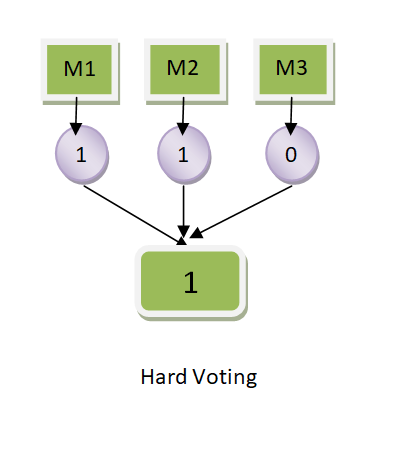
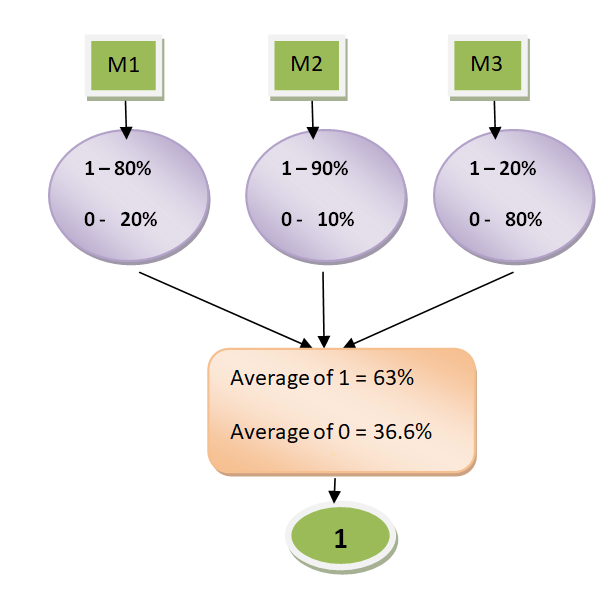

<h2>It seems that soft voting gives better results than hard voting (it is not always the case)

BayesianGaussianMixture can do both !
    
(images form https://vitalflux.com/hard-vs-soft-voting-classifier-python-example/)

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import BayesianGaussianMixture

In [2]:
data = pd.read_csv('../input/tabular-playground-series-jul-2022/data.csv')

In [3]:
best_data =[
'f_07','f_08', 'f_09', 'f_10',
'f_11', 'f_12', 'f_13', 'f_22',
'f_23', 'f_24', 'f_25','f_26',
'f_27', 'f_28']

In [4]:
#Data must be transformed into gaussian shape : (directly) 
pt = PowerTransformer()
data_scaled = pt.fit_transform(data[best_data])
data_scaled = pd.DataFrame(data_scaled, columns = best_data)
data_scaled.head(3)

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.977987,1.383372,1.039938,-0.567775,1.142180,-0.083596,0.086073,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.977987,-0.875405,-0.179925,-0.837020,-0.420725,1.725834,0.738456,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652
2,0.021718,1.017648,-0.394246,0.124844,0.296135,-0.928325,1.118063,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373


In [5]:
# Bizen made a hard voting (with mode), I changed it to a soft voting :

values = [0,1,2,3,4,5,6]
pred_test = pd.DataFrame(np.zeros((data_scaled.shape[0],7)), columns = values)

for seed in tqdm(range(100)):
    
    df = pd.DataFrame(index = data.index)
    gmm = BayesianGaussianMixture(
            n_components=7,
            random_state = seed,
            tol = 0.01,
            covariance_type = 'full',
            max_iter = 100,
            n_init=3
          )
    
    # fitting and probability prediction
    gmm.fit(data_scaled)
    pred_seed = gmm.predict_proba(data_scaled) # predict_proba for probabilities
    
    # the clusters prediction for the current seed :
    MAX = np.argmax(pred_seed, axis=1)
    df[f'pred_{seed}'] = MAX
    
    # Sort of the prediction by same value of cluster (for addition of every seed)
    pred_keys = df[f'pred_{seed}'].value_counts().index.tolist()
    pred_dict = dict(zip(pred_keys, values))
    df[f'pred_{seed}'] = df[f'pred_{seed}'].map(pred_dict)

    pred_new = pd.DataFrame(pred_seed).rename(columns = pred_dict)
    pred_new = pred_new.reindex(sorted(pred_new.columns), axis=1)
    pred_test += pred_new # Soft voting by probabiliy addition

predictions = np.argmax(np.array(pred_test), axis=1)

 86%|████████▌ | 86/100 [2:14:26<21:15, 91.12s/it]/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
100%|██████████| 100/100 [2:36:58<00:00, 94.19s/it] 


In [6]:
submission = pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")
submission["Predicted"] = predictions
submission.to_csv('submission_simple_soft_voting.csv',index = False)
submission

,Id,Predicted
0,0,3
1,1,6
2,2,3
3,3,4
4,4,0
...,...,...
97995,97995,6
97996,97996,2
97997,97997,1
97998,97998,5
